# Contents

1. Setup
2. Read in variables from YAML configuration file
3. Read in the processed data
4. Plot Explained Variance of Components
5. Perform Principal Component Analysis (PCA)

# --------------------------------------------------------------------------------------------------------
# 1. Setup
# --------------------------------------------------------------------------------------------------------

### Import relevant packages

##### General packages

In [1]:
import os
import pandas as pd
from tqdm.auto import tqdm

##### Packages for the YAMl file

In [2]:
import yaml

##### Packages for scaling the data

In [3]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler

##### Packages for exporting the PCA model

In [4]:
from joblib import dump

### Set the maximum output number of columns and rows

In [5]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

### Load in the '.py' file containg the functions used in this notebook¶

In [6]:
%load_ext autoreload
%autoreload 1
%aimport pca

import pca

# --------------------------------------------------------------------------------------------------------
# 2. Read in the variables from the YAML config file
# --------------------------------------------------------------------------------------------------------

### Read in YAML configuration file

In [7]:
with open("../../Config_files/config.yaml", "r") as variables:
    config_variables = yaml.load(variables, Loader=yaml.FullLoader)

### Set the needed variables from this config file

##### Read in the data directory filepath

In [8]:
data_directory = config_variables["data_directory"]

##### Read in the directory to output the PCA model to

In [9]:
model_directory = config_variables["model_directory"]

##### Read the random seed

In [10]:
random_seed = config_variables["random_seed"]

##### Read the time intervals

In [11]:
train_intervals_list = config_variables["train_intervals_list"]

##### Read list of feature numbers

In [12]:
num_pca_features_list = config_variables["num_pca_features_list"]

# --------------------------------------------------------------------------------------------------------
# 3. Read in the processed data
# --------------------------------------------------------------------------------------------------------

At this stage, all the data is collected, processed, and stored in a CSV.

There is one entry in this data for each day between the start and end date. This start date would have been specified in the *scrape_config.yaml* file and would have been used to dictate the dates scraped in the data collection step.

In the case when data for any of the features didn't exist before a certain date, the values for this feature before this date will apppear as *NaN*.
These dates can be easily seen in the *data_processing.ipynb* notebook and they should be used to dictate the date interval specified to use in the modelling process.
The dates for these chosen intervals can be specified in the *config.yaml* file under the variable *train_intervals_list*.

### Read in the data

In [15]:
processed_data = pd.read_csv(os.path.join(data_directory, 'Processed_data', 'full_processed_data.csv'))

### Manually inspect this data

In [16]:
processed_data.shape

(4715, 1429)

In [17]:
processed_data.head()

,date,trading_volume,trades_per_minute,volatility,bid_and_ask_spread,bid_and_ask_sum_asks,bid_and_ask_sum_bids,time_between_blocks,block_size_votes,rank_bit_x,rank_bitfinex,rank_bitstamp,rank_btce,rank_coinbase,rank_itbit,rank_kraken,rank_mtgox,rank_okcoin,rank_others,marketcap3sma,marketcap7sma,marketcap14sma,marketcap30sma,marketcap90sma,marketcap3ema,marketcap7ema,marketcap14ema,marketcap30ema,marketcap90ema,marketcap3wma,marketcap7wma,marketcap14wma,marketcap30wma,marketcap90wma,marketcap3trx,marketcap7trx,marketcap14trx,marketcap30trx,marketcap90trx,marketcap3mom,marketcap7mom,marketcap14mom,marketcap30mom,marketcap90mom,marketcap3std,marketcap7std,marketcap14std,marketcap30std,marketcap90std,marketcap3var,...,us_5_yr_5_yr_fwd_inflatn_expectation,us_ted_spread,us_prime_loan_rate,us_unemployment_rate,us_long_natural_unemployment_rate,us_short_natural_unemployment_rate,us_labour_force_employ_rate,us_pop_employ_rate,us_num_unemployed,us_nonfarm_num_employed,us_num_employed_in_manufactoring,us_num_filing_for_unemployment,us_median_house_income,us_total_real_disposable_income,us_tot_personal_consumption_spend,us_tot_personal_consumption_spend_dg,us_percent_personal_saving_rate,us_real_retail_and_food_sales,us_total_disposble_income,us_industry_production_index,us_capacity_utilisation,us_new_housing_devs_started,us_gross_private_domestic_investment,us_corporate_profit_aftr_tax,us_financial_stress_index,west_texas_crude_oil_price,us_leading_index,us_currency_trade_weighted_dollar_index,us_broad_trade_weighted_dollar_index,us_total_public_debt,us_public_debt_as_perc_of_gdp,us_bank_excess_capital_reserves,us_total_commercial_loans,us_10_year_yield,us_5_year_yield,us_3_year_yield,us_2_year_yield,musk_num_tweets,musk_num_pos_tweets,musk_num_neg_tweets,musk_num_neut_tweets,musk_percent_pos,musk_percent_neg,musk_percent_neut,cos_dotw,sin_dotw,cos_dotm,sin_dotm,shifted_1,binary_price_change_1
0,2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.25,7.8,4.875262,5.212292,65.7,60.6,12058.0,134055.0,12561.0,NaN,60200.0,11718.0,9847.2,1023.0,6.2,158979.0,10921.5,88.583,69.819,490.0,2014.878,1082.708,NaN,NaN,-2.32,NaN,NaN,11126941.0,77.10496,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000e+00,0.841254,0.540641,NaN,0
1,2009-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.59,1.33,3.25,7.8,4.875262,5.212292,65.7,60.6,12058.0,134055.0,12561.0,NaN,60200.0,11718.0,9847.2,1023.0,6.2,158979.0,10921.5,88.583,69.819,490.0,2014.878,1082.708,3.246,46.17,-2.32,79.2570,107.2518,11126941.0,77.10496,NaN,NaN,2.9618,1.7680,1.0916,0.7202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,8.660254e-01,0.841254,0.540641,NaN,0
2,2009-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.59,1.33,3.25,7.8,4.875262,5.212292,65.7,60.6,12058.0,134055.0,12561.0,503000.0,60200.0,11718.0,9847.2,1023.0,6.2,158979.0,10921.5,88.583,69.819,490.0,2014.878,1082.708,3.246,46.17,-2.32,79.2570,107.2518,11126941.0,77.10496,NaN,NaN,2.9618,1.7680,1.0916,0.7202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5,8.660254e-01,0.841254,0.540641,NaN,0
3,2009-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.59,1.33,3.25,7.8,4.875262,5.212292,65.7,60.6,12058.0,134055.0,12561.0,503000.0,60200.0,11718.0,9847.2,1023.0,6.2,158979.0,10921.5,88.583,69.819,490.0,2014.878,1082.708,3.246,46.17,-2.32,79.2570,107.2518,11126941.0,77.10496,NaN,NaN,2.9618,1.7680,1.0916,0.7202,0.0,0.0,0.0,0.0,

In [18]:
processed_data.tail()

,date,trading_volume,trades_per_minute,volatility,bid_and_ask_spread,bid_and_ask_sum_asks,bid_and_ask_sum_bids,time_between_blocks,block_size_votes,rank_bit_x,rank_bitfinex,rank_bitstamp,rank_btce,rank_coinbase,rank_itbit,rank_kraken,rank_mtgox,rank_okcoin,rank_others,marketcap3sma,marketcap7sma,marketcap14sma,marketcap30sma,marketcap90sma,marketcap3ema,marketcap7ema,marketcap14ema,marketcap30ema,marketcap90ema,marketcap3wma,marketcap7wma,marketcap14wma,marketcap30wma,marketcap90wma,marketcap3trx,marketcap7trx,marketcap14trx,marketcap30trx,marketcap90trx,marketcap3mom,marketcap7mom,marketcap14mom,marketcap30mom,marketcap90mom,marketcap3std,marketcap7std,marketcap14std,marketcap30std,marketcap90std,marketcap3var,...,us_5_yr_5_yr_fwd_inflatn_expectation,us_ted_spread,us_prime_loan_rate,us_unemployment_rate,us_long_natural_unemployment_rate,us_short_natural_unemployment_rate,us_labour_force_employ_rate,us_pop_employ_rate,us_num_unemployed,us_nonfarm_num_employed,us_num_employed_in_manufactoring,us_num_filing_for_unemployment,us_median_house_income,us_total_real_disposable_income,us_tot_personal_consumption_spend,us_tot_personal_consumption_spend_dg,us_percent_personal_saving_rate,us_real_retail_and_food_sales,us_total_disposble_income,us_industry_production_index,us_capacity_utilisation,us_new_housing_devs_started,us_gross_private_domestic_investment,us_corporate_profit_aftr_tax,us_financial_stress_index,west_texas_crude_oil_price,us_leading_index,us_currency_trade_weighted_dollar_index,us_broad_trade_weighted_dollar_index,us_total_public_debt,us_public_debt_as_perc_of_gdp,us_bank_excess_capital_reserves,us_total_commercial_loans,us_10_year_yield,us_5_year_yield,us_3_year_yield,us_2_year_yield,musk_num_tweets,musk_num_pos_tweets,musk_num_neg_tweets,musk_num_neut_tweets,musk_percent_pos,musk_percent_neg,musk_percent_neut,cos_dotw,sin_dotw,cos_dotm,sin_dotm,shifted_1,binary_price_change_1
4710,2021-11-24,5661.806460,119.848889,112.522703,1.513739,3.204000e+07,1.002368e+08,8.141667,20.0,0.021572,2058.125500,366.272559,1198.635333,1140.771794,251.796533,594.514759,23.146947,1123.792028,161.251842,1.076167e+12,1.092176e+12,1.143873e+12,1.162191e+12,1.023935e+12,1.078588e+12,1.098451e+12,1.125758e+12,1.135610e+12,1.043831e+12,1.074257e+12,1.086328e+12,1.114505e+12,1.152111e+12,1.090419e+12,-0.862,-0.770,-0.064,0.429,0.218,-4.446043e+10,-5.821156e+10,-1.891425e+11,-1.089483e+11,1.814663e+11,9.849844e+09,3.623002e+10,1.183352e+11,1.069189e+11,2.893261e+11,2.425485e+19,...,2.19,0.11,3.25,4.6,4.450651,4.450651,61.6,58.8,7419.0,148319.0,12529.0,199000.0,67521.0,15425.2,16290.7,2076.5,7.3,230623.0,18108.3,101.611,76.3674,1520.0,4090.667,2742.138,-0.07,76.74,1.72,90.8221,128.0097,28529436.0,125.45397,2854690.0,2436.4397,1.755,1.0914,0.7936,0.5963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-2.449294e-16,1.0,-1.133108e-15,58323.714436,1
4711,2021-11-25,5057.482717,112.791806,108.654990,1.540022,3.668729e+07,1.006372e+08,8.141667,20.0,0.020861,1931.775241,369.658249,1198.635333,1351.680054,251.796533,467.783480,23.146947,1123.792028,158.377601,1.081359e+12,1.089876e+12,1.134865e+12,1.159615e+12,1.026175e+12,1.088573e+12,1.098478e+12,1.122131e+12,1.133220e+12,1.045034e+12,1.085452e+12,1.087923e+12,1.108463e+12,1.148005e+12,1.092059e+12,-0.407,-0.747,-0.113,0.408,0.220,1.557422e+10,-1.609508e+10,-1.261190e+11,-7.727572e+10,2.016454e+11,2.440743e+10,3.203183e+10,1.113546e+11,1.091796e+11,2.884786e+11,1.489306e+20,...,2.19,0.11,3.25,4.6,4.450651,4.450651,61.6,58.8,7419.0,148319.0,12529.0,199000.0,67521.0,15425.2,16290.7,2076.5,7.3,230623.0,18108.3,101.611,76.3674,1520.0,4090.667,2742.138,-0.07,76.74,1.72,90.8221,128.0097,28529436.0,125.45397,2854690.0,2436.4397,1.755,1.0914,0.7936,0.5963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000e+00,1.0,-1.133108e-15,55945.976834,0
4712,2021-11-26,12721.213799,213.395278,154.675175,1.920435,3.668729e+07,1.006372e+08,8.141667,20.0,0.020210,1705.968533,385.889296,1198.635333,1351.680054,251.796533,479.332281,23.146947,1123.792028

# --------------------------------------------------------------------------------------------------------
# 4. Plot Explained Variance of Components
# --------------------------------------------------------------------------------------------------------

As mentioned above, we have to specify an interval to run this analysis on by selecting a start and end date in the *config.yaml* file.
This interval is written as a list so that multiple intervals can be chosen, allowing us to iteratively apply PCA across the different intervals.
After we have subset the data on our desired time interval, those features which still contain any NaN values will be dropped from the data.

This step plots the explained variance of each component derived from the data over each specified interval.
This allows us to see the point when adding another component doesn't explain and more variance in the data than we did previously.
We can also see the number of components needed to explain a certain % of the variance in the data.
This is crucial to selecting the number of features we want in the dataset we output after the principal component analysis is done.

### Set the estimator used to scale the data before carrying out the PCA

In [19]:
estimator = [['minmax', MinMaxScaler(feature_range=(-1, 1))],
            ]

### Iterate through the intervals and plot their explained variance

-------------
Time Interval: 2015-08-17 --> 2020-12-31

Dropping the following 'Nan' columns:
 ['france_gov_debt_all', 'denmark_gov_debt_all', 'sweden_gov_debt_all'] 



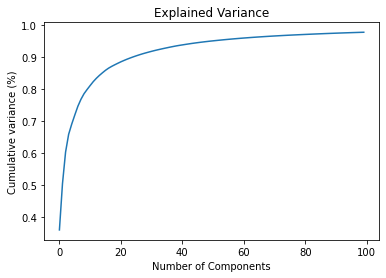

|    |   component_num |   explained_variance |   cumulative_explained_variance |
|---:|----------------:|---------------------:|--------------------------------:|
|  0 |               0 |          0.361075    |                        0.361075 |
|  1 |               1 |          0.144663    |                        0.505738 |
|  2 |               2 |          0.0982429   |                        0.603981 |
|  3 |               3 |          0.0555272   |                        0.659508 |
|  4 |               4 |          0.0318366   |                        0.691345 |
|  5 |               5 |          0.0283772   |                        0.719722 |
|  6 |               6 |          0.0273416   |                        0.747064 |
|  7 |               7 |          0.021704    |                        0.768767 |
|  8 |               8 |          0.0174716   |                        0.786239 |
| 10 |              10 |          0.0124313   |                        0.811868 |
| 12 |          

In [22]:
interval_to_data = {}
for train_start_date, train_end_date in tqdm(train_intervals_list):
    print("-------------\nTime Interval:", train_start_date, "-->", train_end_date)
    time_interval_str = '{}_to_{}'.format(train_start_date, train_end_date)

    # define the train data for this date interval
    train_df = pca.get_subset_of_data(processed_data, train_start_date, train_end_date)

    # drop any features that have Nan's in them
    no_nan_train_df = pca.drop_nan_cols(train_df)
    
    # get a dataframe of the data's features
    train_features, dropped_cols = pca.get_features(no_nan_train_df)

    # scale these features
    scaled_x_train = pca.scale_the_data(estimator, train_features, verbose=False)

    # plot the explained variance
    pca.plot_explained_variance(scaled_x_train, random_seed, num_features=100, max_variance_interval=2.5)
    
    # store the scaled features and the dropped target prices for this interval
    interval_to_data[time_interval_str] = (scaled_x_train, train_df[dropped_cols])

The above plot and table can be used to select the number of features we want to include in our PCA model.
We want to minimise the number of features we retain while also maximising the amount of variance these componnts explain in the underlying data.

The number of PCA components is dictated through the *num_pca_features_list* parameter in the *config.yaml* file.

# --------------------------------------------------------------------------------------------------------
# 5. Perform Principal Component Analysis (PCA)
# --------------------------------------------------------------------------------------------------------

In this step, we perform the PCA on the processed data.

We have already iterated through each interval and have the data stored in the correct format, now we must train a PCA model on each of these datasets for each number of components specified in the *num_pca_features_list* parameter. 

To transform our dataset into a dataset with 'n' features, we first train the PCA model with 'n' components and then transform our dataset using these components. We must then add our target price columns back into the data so that the final dataset represents the features and the targets.

The PCA model used is saved as a *.joblib* file for future use and to keep a record of steps that were carried out. The final transformed dataset is then stored in a directory with the other CSV's of the data post feature selection.

In [23]:
for (time_interval_str, (scaled_x_train, target_cols_df)) in tqdm(interval_to_data.items()):

    # iterate through the number of features to train the model on 
    for num_features in num_pca_features_list:

        # train PCA model
        pca_model = pca.train_pca_model(scaled_x_train, num_features, random_seed)

        # export the model for tranfroming other datasets
        pca_model_path = os.path.join(model_directory, 'PCA', 'pca_{}__{}.joblib'.format(num_features, time_interval_str))
        dump(pca_model, pca_model_path)

        # transform the train features to the PCA models 'n' principal components
        pca_train_features = pd.DataFrame(pca_model.transform(scaled_x_train))

        # add the dropped shifted and binary price change columns back into the data
        for col in target_cols_df.columns:
            pca_train_features[col] = target_cols_df[col]

        # output these table as a dataframe
        train_path = os.path.join(data_directory, 'Feat_select', 'pca_{}__{}.csv'.format(num_features, time_interval_str))
        pca_train_features.to_csv(train_path, index=False)